In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys
import os
core_dir = os.path.join(os.getcwd(), '..', 'daphme')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import garden_city as gcity
from garden_city import Building, Street, City, Agent, Population
import mobility_model as mmod
import stop_detection as sd
from constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS, FAST_STILL_PROBS, SLOW_STILL_PROBS

import pdb

Initialization of city and population

In [2]:
city = gcity.load('garden-city.pkl')
population = Population(city)

# Definitions

In [15]:
def identify_stop(alg_out, sparse_traj, stop_table):
    """
    Given the output of a stop detection algorithm, identifies the cluster by 
    the mode location of pings in the cluster.
    """
    merged_df = pd.merge(alg_out, sparse_traj, left_index=True, right_index=True)
    merged_df['location'] = merged_df.apply(lambda ping: city.get_block((ping.x, ping.y)).id, axis=1)
    mode_locations = merged_df.groupby('cluster')['location'].agg(lambda x: x.mode()[0])
    stop_table['location'] = stop_table['cluster_id'].map(mode_locations)
    return stop_table


def q_stat(agent):
    # How to handle partial hours? If last ping is 18:00, count that hour or not?

    sparse_traj = agent.sparse_traj
    traj = agent.trajectory

    if sparse_traj.empty:
        return 0

    sparse_hours = sparse_traj['local_timestamp'].dt.to_period('h')
    full_hours = traj['local_timestamp'].dt.to_period('h')
    num_hours = sparse_hours.nunique()
    total_hours = full_hours.nunique()
    q_stat = num_hours / total_hours
    return q_stat


def radius_of_gyration(df):
    rog = np.sqrt(np.nanmean(np.nansum((df.to_numpy() - np.nanmean(df.to_numpy(), axis=0))**2, axis=1)))
    return rog


def expand_timestamps(df):
    """
    Expands timestamps to individual minutes.
    """
    # Repeat rows based on duration
    repeated_df = df.loc[df.index.repeat(df['duration'])].reset_index(drop=True)

    # Generate the time increments
    repeated_df['minute_increment'] = repeated_df.groupby(['local_timestamp', 'stop_id']).cumcount()
    repeated_df['local_timestamp'] = repeated_df['local_timestamp'] + pd.to_timedelta(repeated_df['minute_increment'], unit='m')
    expanded = repeated_df.drop(columns=['minute_increment', 'duration'])

    expanded['unix_timestamp'] = expanded['local_timestamp'].astype('int64') // 10**9
    expanded = expanded.set_index('unix_timestamp', drop=True)

    return expanded


def prepare_diary(agent):
    """
    Create stop ids, expand to minute level, and filter diary
    to stops that have at least one ping in the sparse trajectory.
    """
    diary = agent.diary.copy()
    diary['x'] = diary['location'].apply(lambda b: city.buildings[b].geometry.centroid.x if b is not None else None)
    diary['y'] = diary['location'].apply(lambda b: city.buildings[b].geometry.centroid.y if b is not None else None)

    sparse_traj = agent.sparse_traj

    # stop_id of trips is -1. Stays are id'ed as 0, 1, 2, ...
    mask = diary['location'].notna()
    diary['stop_id'] = np.where(mask, np.cumsum(mask) - 1, -1)

    # Expand to minute level
    prepared_diary = expand_timestamps(diary)

    # Filter diary to stops that have at least one ping in the sparse trajectory
    stop_ids = prepared_diary['stop_id']
    idx = stop_ids.index.intersection(sparse_traj.index)
    stop_ids = stop_ids.loc[idx]
    stop_ids = pd.concat([stop_ids, pd.Series([-1], name="stop_id")], ignore_index=True)  # ensure trips are kept
    keep = stop_ids.unique()

    prepared_diary = prepared_diary[prepared_diary['stop_id'].isin(keep)]
    return prepared_diary, diary


def prepare_stop_table(stop_table, diary):
    """
    Maps detected stops to diary stops via overlapping location and timeframe,
    and expand to minute level
    """
    keep = stop_table.columns.tolist() + ['stop_id']

    stop_table['end_time'] = stop_table['local_timestamp'] + pd.to_timedelta(stop_table['duration'], unit='m')
    diary['end_time'] = diary['local_timestamp'] + pd.to_timedelta(diary['duration'], unit='m')

    # merge_asof gets stop_table['local_timestamp'] <= diary['end_time'] by location
    joined = pd.merge_asof(
        stop_table,
        diary,
        left_on='local_timestamp',
        right_on='end_time',
        by='location',
        suffixes=('', '_diary'),
        direction='forward'
    )

    # Ensure diary['local_timestamp'] <= stop_table['end_time']
    mask = joined['local_timestamp_diary'] <= joined['end_time']

    # Select the first matching stop_id if multiple matches are found
    joined['stop_id'] = joined.loc[mask, 'stop_id']

    diary.drop(columns=['end_time'], inplace=True)
    stop_table = joined[keep]

    prepared_stop_table = expand_timestamps(stop_table)  # expand to minute level

    return prepared_stop_table, stop_table


def cluster_metrics(stop_table, agent):
    """
    Multiclass classification: compute precision, recall for each class separately,
    then use microaveraging to get the overall precision and recall.
    We could also try duration-weighted macroaveraging.
    """

    # Prepare diary
    prepared_diary, diary = prepare_diary(agent)

    # Prepare stop table
    prepared_stop_table, stop_table = prepare_stop_table(stop_table, diary)

    # Count number of rows in stop_table that match each stop_id in diary
    stop_counts = stop_table['stop_id'].value_counts().reset_index()
    stop_counts.columns = ['stop_id', 'stop_count']

    # Merge on timestamps and locations
    prepared_stop_table.loc[:, 'stop_id'] = prepared_stop_table['stop_id'].fillna(-2)  # -2 refers to stops detected by the sd alg that don't exist in ground truth
    joined = prepared_diary.merge(prepared_stop_table, on=['unix_timestamp', 'stop_id'], how='outer', indicator=True)

    # Compute radius of gyrations
    rog_diary = radius_of_gyration(prepared_diary[['x', 'y']])
    rog_stop_table = radius_of_gyration(prepared_stop_table[['centroid_x', 'centroid_y']])
    rog = {'diary': rog_diary, 'stop_table': rog_stop_table}
    
    # Duplicated indices denotes conflicting stop labels for the timestamp
    merging_df = joined[joined.index.duplicated(keep=False)]

    # Calculate metrics for each class
    stops = joined['stop_id'].unique()
    stops = stops[stops != -2]
    stops.sort()
    metrics_data = []

    n_stops = len(stops) - 1

    for s in stops:
        s_joined = joined[joined['stop_id'] == s]
        s_tp = s_joined[s_joined['_merge'] == 'both'].shape[0]
        s_fp = s_joined[s_joined['_merge'] == 'right_only'].shape[0]
        s_fn = s_joined[s_joined['_merge'] == 'left_only'].shape[0]

        s_merging = merging_df[(merging_df['_merge'] == 'left_only') & (merging_df['stop_id'] == s)]
        s_m = s_merging.shape[0]
        s_m_stops = merging_df.loc[s_merging.index]
        s_m_stops = s_m_stops[(s_m_stops['_merge'] == 'right_only')]
        s_m_stops = s_m_stops['stop_id'].nunique()

        metrics_data.append({
            'stop_id': s,
            'tp': s_tp,
            'fp': s_fp,
            'fn': s_fn,
            'precision': s_tp / (s_tp + s_fp) if (s_tp + s_fp) != 0 else 0,
            'recall': s_tp / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0,
            'pings_merged': s_m,
            'stops_merged': s_m_stops,
            'prop_merged': s_m / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0
        })

    trips = metrics_data[0]
    metrics_df = pd.DataFrame(metrics_data[1:])
    metrics_df = diary.merge(metrics_df, on=['stop_id'], how='right')
    metrics_df = metrics_df.merge(stop_counts, on=['stop_id'], how='left')
    metrics_df = metrics_df.set_index('stop_id')
    metrics_df['stop_count'] = metrics_df['stop_count'].fillna(0).astype(int)

    tp = metrics_df['tp'].sum()
    fp = metrics_df['fp'].sum()
    fn = metrics_df['fn'].sum()
    stops_merged = metrics_df['stops_merged'].sum()

    # Calculate micro-averaged precision and recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate macro-averaged precision and merging, weighted by duration of stop
    total_duration = metrics_df['duration'].sum()  # total duration = tp + fn
    weighted_precision = (metrics_df['precision'] * metrics_df['duration']).sum() / total_duration
    weighted_merging = (metrics_df['prop_merged'] * metrics_df['duration']).sum() / total_duration

    # Count number of missed and split stops
    num_missed = metrics_df[metrics_df['stop_count'] == 0].shape[0]
    num_split = metrics_df[metrics_df['stop_count'] > 1].shape[0]

    metrics = {
        "Recall": recall,
        "Precision": precision,
        "Weighted Precision": weighted_precision,
        "Missed": num_missed,
        "Stops Merged": stops_merged,
        "Weighted Stop Merging": weighted_merging,
        "Trip Merging": trips['prop_merged'],
        "Split": num_split,
        "Stop Count": n_stops
    }

    return metrics_df, metrics, rog

# Illustration: One User

Initialize agent with ground-truth trajectory and a sparse sampled trajectory.

In [38]:
# EPR
seed = 110

Paco = Agent('Paco',
             'h-x13-y9',
             'w-x3-y13',
             city,
             start_time=datetime(2024, 1, 1, hour=0, minute=0))

population.add_agent(Paco)
population.generate_trajectory(Paco, T=datetime(2024, 1, 7, hour=0, minute=0), seed=seed)

hier_nhpp_params = (1600, 180, 30)
Paco.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

Agent identifier already exists in population. Replacing corresponding agent.
Seed: 128


In [4]:
seed = 377 

start_time = [datetime(2024, 6, 1, hour=6, minute=0) + timedelta(minutes=60*t) for t in range(9)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*9
location = ['h-x13-y9'] * 2 + ['h-x13-y8'] * 1 + ['w-x18-y8'] * 1 + ['w-x18-y13'] * 1 + ['p-x13-y11'] * 4

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = gcity.condense_destinations(destination)

Paco = Agent('Paco',
             'h-x13-y9',
             'w-x3-y13',
             city,
             destination_diary=destination)

population.add_agent(Paco)
population.generate_trajectory(Paco, seed=seed, dt=1)

hier_nhpp_params = (89, 45, 6)
Paco.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

Plot sparse sampled trajectory.

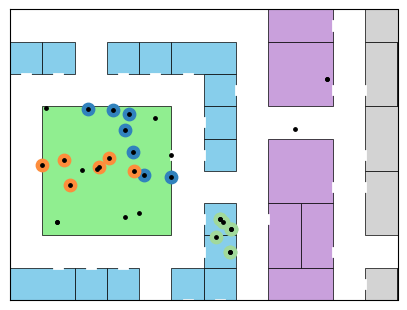

In [5]:
%matplotlib inline

dbscan_params = [(90, 1.1, 2), (60, 0.5, 3)]
dbscan_out = sd.temporal_dbscan(Paco.sparse_traj, *dbscan_params[0])

lachesis_params = [(10, 120, 4), (10, 60, 3)]
lachesis_out = sd.lachesis_patches(Paco.sparse_traj, *lachesis_params[0])

fig, ax = plt.subplots(figsize=(5, 5))

alg2plot = dbscan_out

num_clusters = sum(alg2plot.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = alg2plot[alg2plot.cluster == cid]
    cdata = Paco.sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(Paco.sparse_traj.x, Paco.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

ax.set_xlim(8, 20)
ax.set_ylim(7, 16)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [6]:
Paco_stop_table = sd.generate_stop_table(Paco.sparse_traj, dbscan_out)
#Paco_stop_table['location'] = Paco_stop_table.apply(lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
Paco_stop_table = identify_stop(dbscan_out, Paco.sparse_traj, Paco_stop_table)

Paco_stop_table

,unix_timestamp,local_timestamp,cluster_id,duration,centroid_x,centroid_y,radius,location
0,1717222620,2024-06-01 06:17:00,2,163,14.661326,9.090929,0.430742,h-x13-y9
1,1717240320,2024-06-01 11:12:00,1,38,10.367227,11.097721,0.983503,p-x13-y11
2,1717249020,2024-06-01 13:37:00,0,68,11.678476,12.010791,1.130692,p-x13-y11


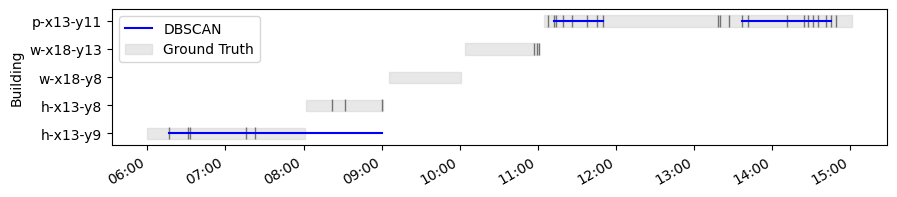

In [7]:
diary = Paco.diary.dropna().copy()
stop_table = Paco_stop_table.copy()
sparse_traj = Paco.sparse_traj.copy()

location_mapping = {loc: idx for idx, loc in enumerate(diary['location'].unique())}
diary['location_num'] = diary['location'].map(location_mapping)
stop_table['location_num'] = stop_table['location'].map(location_mapping)

# Create the plot
plt.figure(figsize=(10, 2))

# Plot stop_table
for idx, row in stop_table.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.plot([start_time, end_time], [row['location_num'], row['location_num']], color='blue', label='DBSCAN' if idx == 0 else "", zorder=3)

# Plot diary data with shaded rectangles
for idx, row in diary.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.fill_between([start_time, end_time], [row['location_num'] - 0.2, row['location_num'] - 0.2], [row['location_num'] + 0.2, row['location_num'] + 0.2], color='lightgrey', alpha=0.5, label='Ground Truth' if idx == 0 else "", zorder=1)
    pings = sparse_traj[(sparse_traj['local_timestamp'] >= start_time) & (sparse_traj['local_timestamp'] <= end_time)]
    pings = pings['local_timestamp'].to_frame()
    pings['location_num'] = row['location_num']
    plt.plot(pings['local_timestamp'], pings['location_num'], '|', markersize=8, color='black', alpha=0.5, zorder=2)

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Building')
plt.yticks(ticks=list(location_mapping.values()), labels=list(location_mapping.keys()))
plt.legend()

plt.show()

In [8]:
diary = Paco.diary.dropna().copy()
stop_table = Paco_stop_table.copy()

df = diary.groupby('location')['duration'].sum().reset_index()
df['type'] = df['location'].apply(lambda b: city.buildings[b].building_type)
df1 = stop_table.groupby('location')['duration'].sum().reset_index()
df = df.merge(df1, on=['location'], how='outer')
df = df.sort_values(by='duration_x', ascending=False)

df['duration_x'] = df['duration_x'] / df['duration_x'].sum()
df['duration_y'] = df['duration_y'] / df['duration_y'].sum()

#df

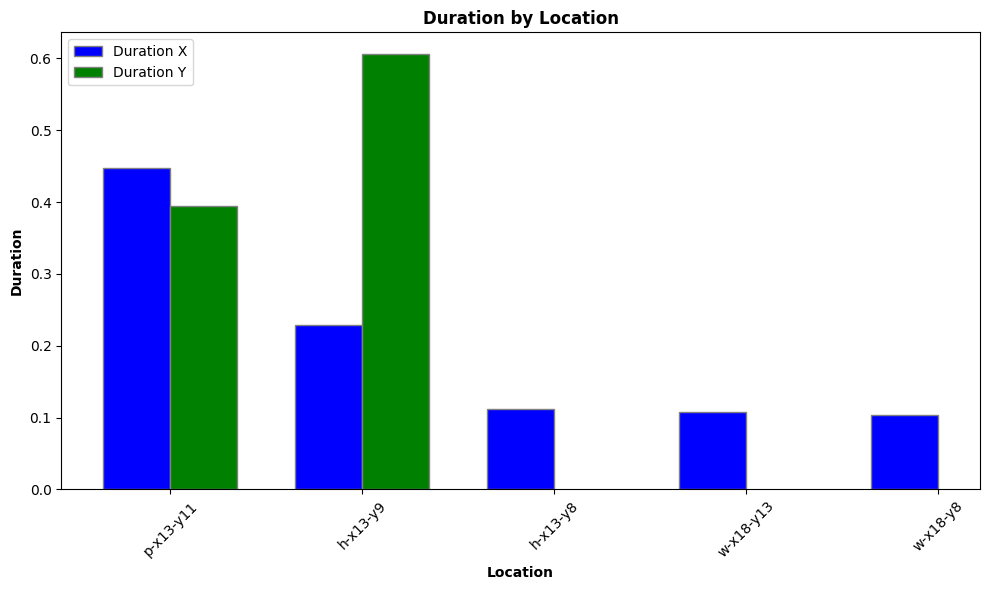

In [9]:
plt.figure(figsize=(10, 6))
bar_width = 0.35

r1 = range(len(df['location']))
r2 = [x + bar_width for x in r1]

plt.bar(r1, df['duration_x'], color='blue', width=bar_width, edgecolor='grey', label='Duration X')
plt.bar(r2, df['duration_y'], color='green', width=bar_width, edgecolor='grey', label='Duration Y')

plt.xlabel('Location', fontweight='bold')
plt.ylabel('Duration', fontweight='bold')
plt.title('Duration by Location', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(df['location']))], df['location'], rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

In [16]:
stop_table = Paco_stop_table.copy()

metrics_df, metrics, rog = cluster_metrics(stop_table, Paco)
metrics

{'Recall': 0.4439746300211416,
 'Precision': 0.7806691449814126,
 'Weighted Precision': 0.6621616363376956,
 'Missed': 2,
 'Stops Merged': 1,
 'Weighted Stop Merging': 0.1226215644820296,
 'Trip Merging': 0.07692307692307693,
 'Split': 1,
 'Stop Count': 4}

In [12]:
metrics_df

,unix_timestamp,local_timestamp,duration,location,x,y,tp,fp,fn,precision,recall,pings_merged,stops_merged,prop_merged,stop_count
stop_id,,,,,,,,,,,,,,,
0,1717221600,2024-06-01 06:00:00,121,h-x13-y9,14.5,9.5,104,59,17,0.638037,0.859504,0,0,0.000000,1
1,1717228920,2024-06-01 08:02:00,59,h-x13-y8,14.5,8.5,0,0,59,0.000000,0.000000,58,1,0.983051,0
3,1717236240,2024-06-01 10:04:00,57,w-x18-y13,17.0,14.0,0,0,57,0.000000,0.000000,0,0,0.000000,0
4,1717239900,2024-06-01 11:05:00,236,p-x13-y11,11.0,11.0,106,0,130,1.000000,0.449153,0,0,0.000000,2


In [17]:
rog

{'diary': 2.629678981737979, 'stop_table': 2.164038410744648}

# Curves

### Fix DBSCAN parameterization: fine vs coarse. Vary burstiness pattern by changing third param (mean gap between pings in a burst) and fixing overall mean of 12 pings per hour.

In [11]:
# Manual

start_time = [datetime(2024, 6, 1, hour=6, minute=0) + timedelta(minutes=60*t) for t in range(18)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*18
location = ['h-x13-y9'] * 2 + ['h-x13-y8'] * 1 + ['w-x3-y13'] * 3 + ['r-x3-y15'] * 1 + ['w-x3-y13'] * 3 + ['w-x8-y18'] * 2 + ['h-x13-y8'] * 2 + ['h-x13-y9'] * 4

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = gcity.condense_destinations(destination)

In [33]:
# EPR
seed = 325

Bethany = Agent('Bethany',
                'h-x13-y9',
                'w-x3-y13',
                city,
                start_time=datetime(2024, 1, 1, hour=0, minute=0))

population.add_agent(Bethany)
population.generate_dest_diary(Bethany, T=datetime(2024, 1, 7, hour=0, minute=0), seed=seed)

hier_nhpp_params = (1600, 180, 30)
Bethany.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

destination = Bethany.destination_diary

Agent identifier already exists in population. Replacing corresponding agent.


In [ ]:
seeds = range(100, 150)
burstiness_range = range(1, 31)
dbscan_params = [(240, 2, 2), (60, 0.5, 3)]
beta_start = 90
pph = 12  # mean pings per hour

results = np.zeros((len(seeds), len(burstiness_range), len(dbscan_params), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, beta_ping in enumerate(burstiness_range):
        beta_durations = (pph * beta_start * beta_ping) / 60
        hier_nhpp_params = (beta_start, beta_durations, beta_ping)
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

        for k, dbscan_param in enumerate(dbscan_params):
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _, rog = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = beta_ping
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Trip Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = None  # q
                continue

            stop_table['location'] = stop_table.apply(lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = beta_ping
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 4] = metrics['Trip Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_burstiness = np.nanmean(results, axis=0)

In [ ]:
import matplotlib.dates as mdates
%matplotlib inline

seed = 120
burstiness_range = range(1, 30)
beta_start = 90
pph = 12 # mean pings per hour

Bethany = Agent('Bethany',
                'h-x13-y9',
                'w-x3-y13',
                city,
                destination_diary=destination)
population.add_agent(Bethany)

population.generate_trajectory(Bethany, seed=seed, dt=1)

fig, axes = plt.subplots(len(burstiness_range), 1, figsize=(10, 9))

for i, beta_ping in enumerate(burstiness_range):
    ax = axes[i]
    beta_durations = (pph * beta_start * beta_ping) / 60
    hier_nhpp_params = (beta_start, beta_durations, beta_ping)
    Bethany.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

    first_ping_timestamps = Bethany.sparse_traj[Bethany.sparse_traj['first_ping'] == 1]['local_timestamp']
    other_timestamps = Bethany.sparse_traj[Bethany.sparse_traj['first_ping'] == 0]['local_timestamp']

    ax.vlines(first_ping_timestamps, 0.95, 1.05, color='red', linewidth=2, alpha=1)
    ax.vlines(other_timestamps, 0.95, 1.05, color='black', linewidth=2, alpha=0.30)

    #ax.vlines(Thomtraj['local_timestamp'], 0.95, 1.05, color='black', linewidth=2, alpha=0.2)

    ax.set_xlim(pd.Timestamp('2024-06-01 08:00'), pd.Timestamp('2024-06-01 17:00'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #plt.xticks(rotation=0)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.text(pd.Timestamp('2024-06-01 17:05'), 0.98, hier_nhpp_params, fontsize=9, ha='left')

axes[-1].xaxis.set_visible(True)
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_burstiness[:, j, :],
            columns=['beta_ping', 'recall', 'precision', 'weighted_stop_merging', 'trip_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['beta_ping'], results_df.iloc[:, i+1],
                label=['Coarse', 'Fine'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. Sparsity', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_burstiness.png")
plt.show()

### Fix DBSCAN parameterization: fine vs coarse. Vary sparsity by changing pings per hour.

In [34]:
def process_seed(seed, sparsity_range, dbscan_params, lachesis_params,
                 beta_start, beta_ping, city, destination):
    print(seed)
    results_dbscan = []
    results_lachesis = []

    Bethany = Agent('Bethany', 'h-x13-y9', 'w-x3-y13', city, destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for pph in sparsity_range:
        beta_durations = (pph * beta_start * beta_ping) / 60
        hier_nhpp_param = (beta_start, beta_durations, beta_ping)
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)
        qstat = q_stat(Bethany)

        for k in range(len(dbscan_params)):
            dbscan_param = dbscan_params[k]
            lachesis_param = lachesis_params[k]

            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            lachesis_out = sd.lachesis_patches(Bethany.sparse_traj, *lachesis_param)

            stop_table_dbscan = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)
            stop_table_lachesis = sd.generate_stop_table(Bethany.sparse_traj, lachesis_out)

            result_dbscan = {
                'seed': seed,
                'alg_param': ['coarse', 'medium', 'fine'][k],
                'q': qstat,
                'recall': 0,
                'precision': 0,
                'stop_merging': None,
                'trip_merging': None,
                'missed': 0,
                'split': None,
                'rog_diary': 0,
                'rog_alg': 0
            }

            result_lachesis = result_dbscan.copy()

            if stop_table_dbscan.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_dbscan.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_dbscan = identify_stop(dbscan_out, Bethany.sparse_traj, stop_table_dbscan)
                # stop_table_dbscan['location'] = stop_table_dbscan.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_dbscan, Bethany)
                result_dbscan.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged']/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed']/metrics['Stop Count'],
                    'split': metrics['Split']/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

            if stop_table_lachesis.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_lachesis.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_lachesis = identify_stop(lachesis_out, Bethany.sparse_traj, stop_table_lachesis)
                # stop_table_lachesis['location'] = stop_table_lachesis.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_lachesis, Bethany)
                result_lachesis.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged']/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed']/metrics['Stop Count'],
                    'split': metrics['Split']/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

                results_dbscan.append(result_dbscan)
                results_lachesis.append(result_lachesis)

    return pd.DataFrame(results_dbscan), pd.DataFrame(results_lachesis)


seeds = range(400, 500)
sparsity_range = range(1, 15)
dbscan_params = [(240, 4, 2), (120, 2, 3), (60, 0.5, 4)]
lachesis_params = [(10, 90, 4), (10, 60, 3), (10, 30, 1.5)]
beta_start = 300
beta_ping = 3

with ProcessPoolExecutor() as executor:
    work = partial(process_seed, sparsity_range=sparsity_range, 
                   dbscan_params=dbscan_params, lachesis_params=lachesis_params,
                   beta_start=beta_start, beta_ping=beta_ping, city=city, destination=destination)
    all_results = list(executor.map(work, seeds))

results_dbscan = [result[0] for result in all_results]
results_lachesis = [result[1] for result in all_results]

results_dbscan = pd.concat(results_dbscan, ignore_index=True)
results_lachesis = pd.concat(results_lachesis, ignore_index=True)

results_dbscan.to_pickle('results-sparsity-dbscan-325.pkl')
results_lachesis.to_pickle('results-sparsity-lachesis-325.pkl')

400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471472

473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
494493

495
496
497
498
499


In [36]:
# Create bins for q, size 0.05 from 0 to 1
bins = np.arange(0, 1.05, 0.05)
labels = [i/100+0.025 for i in range(0, 100, 5)]
results_dbscan['q_bin'] = pd.cut(results_dbscan['q'], bins=bins, labels=labels, include_lowest=True)
results_lachesis['q_bin'] = pd.cut(results_lachesis['q'], bins=bins, labels=labels, include_lowest=True)

results_dbscan_sparsity = results_dbscan.groupby(['q_bin', 'alg_param'], observed=True).mean().reset_index()
counts = results_dbscan.groupby(['q_bin', 'alg_param'], observed=True).size().reset_index(name='count')
results_dbscan_sparsity = results_dbscan_sparsity.merge(counts, on=['q_bin', 'alg_param'])
results_dbscan_sparsity = results_dbscan_sparsity[results_dbscan_sparsity['count'] >= 10]

results_lachesis_sparsity = results_lachesis.groupby(['q_bin', 'alg_param'], observed=True).mean().reset_index()
counts = results_lachesis.groupby(['q_bin', 'alg_param'], observed=True).size().reset_index(name='count')
results_lachesis_sparsity = results_lachesis_sparsity.merge(counts, on=['q_bin', 'alg_param'])
results_lachesis_sparsity = results_lachesis_sparsity[results_lachesis_sparsity['count'] >= 10]

In [37]:
results_dbscan_sparsity

,q_bin,alg_param,seed,q,recall,precision,stop_merging,trip_merging,missed,split,rog_diary,rog_alg,count
3,0.125,coarse,447.700000,0.134943,0.131611,0.952774,0.053143,0.014781,0.331614,0.033603,4.673492,4.695104,30
4,0.125,fine,447.700000,0.134943,0.043330,0.998671,0.000000,0.000703,0.633768,0.059635,4.673492,4.139558,30
5,0.125,medium,447.700000,0.134943,0.087539,0.984548,0.022843,0.006012,0.417076,0.052813,4.673492,4.872141,30
6,0.175,coarse,449.056604,0.180156,0.179490,0.870544,0.135119,0.036028,0.343320,0.036885,4.791118,5.208663,106
7,0.175,fine,449.056604,0.180156,0.081659,0.997192,0.002534,0.002058,0.515766,0.095549,4.791118,4.945177,106
8,0.175,medium,449.056604,0.180156,0.123887,0.961102,0.052805,0.014283,0.373414,0.065384,4.791118,5.366961,106
9,0.225,coarse,449.591241,0.228694,0.236754,0.843905,0.192185,0.060422,0.325746,0.035035,4.947927,5.370898,137
10,0.225,fine,449.591241,0.228694,0.131225,0.996390,0.004308,0.003711,0.456198,0.133900,4.947927,5.297205,137
11,0.225,medium,449.591241,0.228694,0.182671,0.949010,0.082819,0.025463,0.311975,0.069924,4.947927,5.592681,137
12,0.275,coarse,449.412791,0.277706,0.307161,0.842143,0.252752,0.090852,0.334258,0.034933,5.031624,5.485829,172


In [38]:
results_lachesis_sparsity

,q_bin,alg_param,seed,q,recall,precision,stop_merging,trip_merging,missed,split,rog_diary,rog_alg,count
3,0.125,coarse,447.700000,0.134943,0.075122,0.974681,0.028926,0.006586,0.380196,0.094945,4.673492,5.058356,30
4,0.125,fine,447.700000,0.134943,0.053022,0.994478,0.007120,0.002360,0.432787,0.128708,4.673492,5.037278,30
5,0.125,medium,447.700000,0.134943,0.063394,0.987473,0.015835,0.005299,0.394680,0.119184,4.673492,5.132054,30
6,0.175,coarse,449.056604,0.180156,0.114649,0.955521,0.063811,0.015505,0.347386,0.106807,4.791118,5.481551,106
7,0.175,fine,449.056604,0.180156,0.087071,0.992727,0.010804,0.004417,0.384298,0.150267,4.791118,5.442136,106
8,0.175,medium,449.056604,0.180156,0.101924,0.974566,0.042999,0.011157,0.343863,0.123360,4.791118,5.554543,106
9,0.225,coarse,449.591241,0.228694,0.168590,0.949537,0.094470,0.027643,0.297439,0.111216,4.947927,5.729863,137
10,0.225,fine,449.591241,0.228694,0.139603,0.990472,0.016732,0.008234,0.324021,0.175959,4.947927,5.667111,137
11,0.225,medium,449.591241,0.228694,0.154276,0.968352,0.061642,0.020008,0.293370,0.138775,4.947927,5.763924,137
12,0.275,coarse,449.412791,0.277706,0.247257,0.945194,0.121550,0.044082,0.266144,0.111521,5.031624,5.770680,172


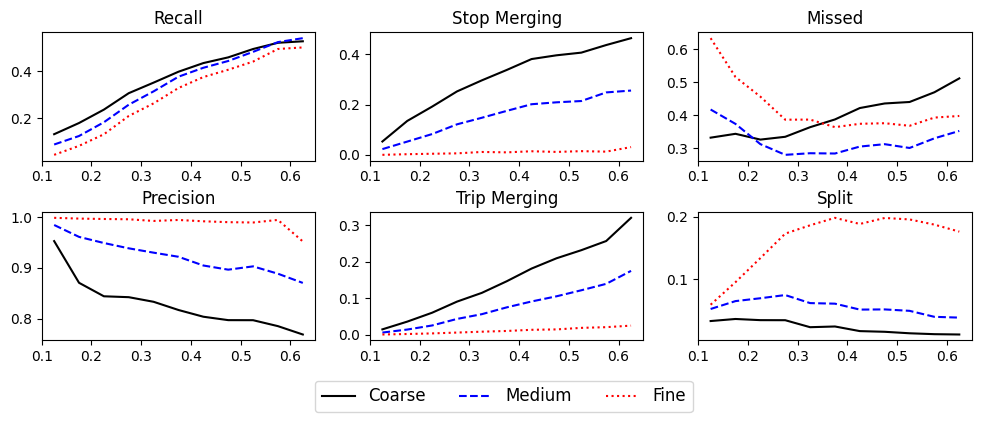

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i in range(6):
    ax = axes[i % 2, i//2]
    for j in range(3):
        setting = ['coarse', 'medium', 'fine'][j]
        results_df = results_dbscan_sparsity[results_dbscan_sparsity['alg_param']==setting]
        ax.plot(results_df['q_bin'], results_df.iloc[:, i+4],
                label=['Coarse', 'Medium', 'Fine'][j],
                color=['black', 'blue', 'red'][j],
                linestyle=['-', '--', ':'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. Sparsity', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.09))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.savefig("metrics_vs_sparsity-dbscan.png")
plt.show()

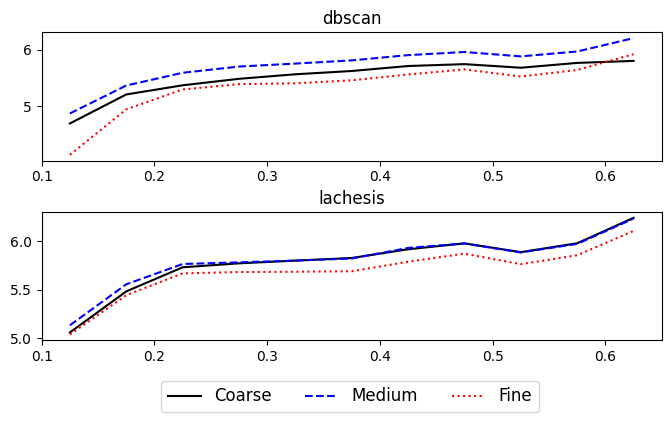

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4))

for i in range(2):
    ax = axes[i]
    results_alg = [results_dbscan_sparsity, results_lachesis_sparsity][i]
    for j in range(3):
        setting = ['coarse', 'medium', 'fine'][j]
        results_df = results_alg[results_alg['alg_param']==setting]
        ax.plot(results_df['q_bin'], results_df['rog_alg'],
                label=['Coarse', 'Medium', 'Fine'][j],
                color=['black', 'blue', 'red'][j],
                linestyle=['-', '--', ':'][j])
    ax.set_title(['dbscan', 'lachesis'][i])
    ax.set_ylabel('')

#fig.suptitle('Metrics v.s. Sparsity', fontsize=20)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.09))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

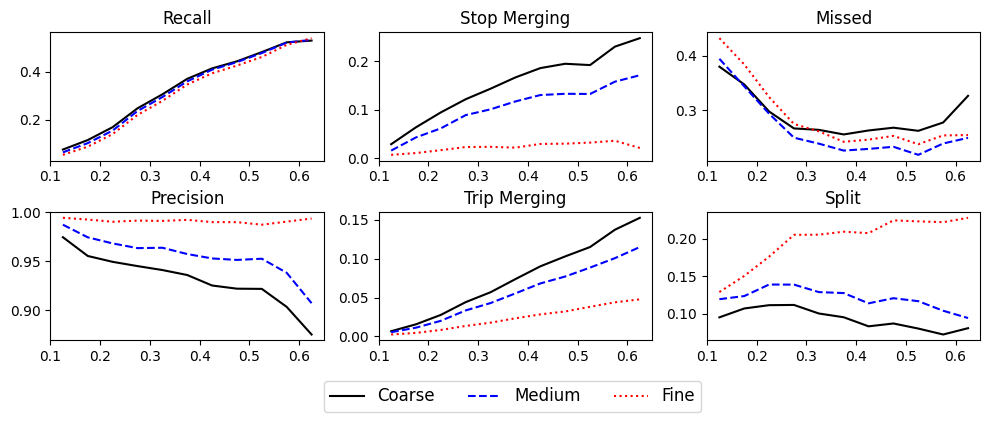

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i in range(6):
    ax = axes[i % 2, i//2]
    for j in range(3):
        setting = ['coarse', 'medium', 'fine'][j]
        results_df = results_lachesis_sparsity[results_lachesis_sparsity['alg_param']==setting]
        ax.plot(results_df['q_bin'], results_df.iloc[:, i+4],
                label=['Coarse', 'Medium', 'Fine'][j],
                color=['black', 'blue', 'red'][j],
                linestyle=['-', '--', ':'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. Sparsity', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.09))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.savefig("metrics_vs_sparsity-lachesis.png")
plt.show()

In [ ]:
#You know what would be interesting and easy to visualize once we have 2 weeks + of trajectory? 
#The actual distribution of locations visited (weighted by hour) vs the detected one. 
#It kind of generalizes the % time home thing, same groupby.

### Fix sparsity. Vary DBSCAN parameters.

In [17]:
seeds = range(100, 150)
hier_nhpp_params = [(90, 30, 4), (60, 60, 2)]  # 3pph, 12pph

# dbscan_params = (time_thresh, dist_thresh, min_pts)
dist_threshs = np.arange(5/15, 200/15, 0.25)

results = np.zeros((len(seeds), len(hier_nhpp_params), len(dist_threshs), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, hier_nhpp_param in enumerate(hier_nhpp_params):
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)
        truepph = round(len(Bethany.sparse_traj) * 2 / 9) / 2
        print(truepph)

        for k, dist_thresh in enumerate(dist_threshs):
            dbscan_param = (240, dist_thresh, 2)
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = dist_thresh
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Trip Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = q_stat(Bethany)  # q
                continue

            stop_table['location'] = stop_table.apply(
                lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = dist_thresh
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            #results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 3] = metrics['Stops Merged']
            results[i, j, k, 4] = metrics['Trip Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_param = np.nanmean(results, axis=0)

6.0
18.0
100
8.5
28.0
101
6.0
29.0
102
5.5
27.0
103
7.5
15.5
104
5.5
18.5
105
6.0
24.5
106
7.0
25.0
107
9.5
28.5
108
6.5
16.5
109
9.0
25.0
110
6.0
22.0
111
8.0
27.0
112
10.0
28.5
113
8.5
29.0
114
5.0
16.5
115
3.0
16.5
116
3.0
19.0
117
4.5
15.0
118
4.0
17.5
119
4.5
17.5
120
6.0
21.0
121
5.0
19.5
122
6.5
15.5
123
6.0
19.5
124
7.5
23.5
125
14.0
25.0
126
8.5
27.0
127
8.0
22.0
128
5.0
18.5
129
7.5
28.5
130
4.5
20.5
131
1.0
9.0
132
3.5
21.5
133
7.5
26.0
134
3.0
15.0
135
10.0
19.5
136
5.0
15.5
137
6.5
34.5
138
8.0
23.5
139
5.5
23.0
140
8.5
24.0
141
4.5
17.5
142
6.5
27.5
143
6.0
23.0
144
6.0
21.0
145
6.0
22.5
146
7.0
22.0
147
8.0
25.0
148
1.5
9.5
149


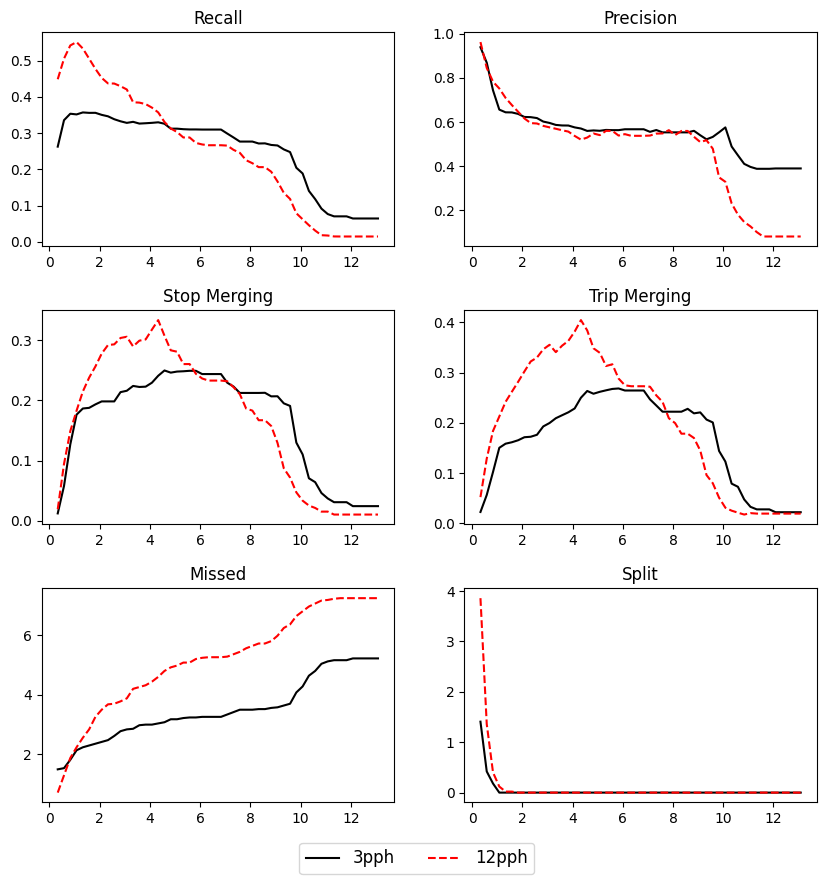

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_param[j, :, :],
            columns=['dist_thresh', 'recall', 'precision', 'weighted_stop_merging', 'trip_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['dist_thresh'], results_df.iloc[:, i+1],
                label=['3pph', '12pph'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. DBSCAN parameters', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_params.png")
plt.show()